In [30]:
#= 
import relevant packages.
this can take a lot of time the first time as it has to precompile 
=#

using DifferentialEquations, Plots, PlotThemes
theme(:juno)

In [31]:
function solve_SIR(model, u0, p, tspan; kw...)
    """ 
    Wrapper for solving the given model f with initial conditions
    u0, parameter vector p and tuple tspan.
    Returns a ODESolution object which can easily be used for plotting
    """
    
    problem = ODEProblem(model, u0, tspan, p)
    sol = solve(problem; kw...)

    return sol
end

solve_SIR (generic function with 1 method)

In [32]:
function f!(du, u, p, t)
    """ Naïve SIR model """
    
    S, I = u
    γ, β = p
    
    du[1] = -β*S*I
    du[2] = β*S*I - γ*I   
    du[3] = γ*I
end

f! (generic function with 1 method)

### Experiment 1.1: Time Series of Epidemic and no Epidemic

$$R_0 > 1$$

In [37]:
### parameters to test for ###
βs = [2.0, 6.0, 0.25, 0.99]
γs = [0.6, 1.0, 0.5, 1.0]

# initial conditions for epidemic
I0e = 0.01
S0e = 1.0

# initial conditions for no epidemic
I0ne = 0.4
S0ne = 0.6

# pack the initial conditions and parameter pairs for each experiment
u0s = [[S0e,  I0e,  0], 
       [S0e,  I0e,  0], 
       [S0ne, I0ne, 0],
       [S0ne, I0ne, 0]]

ps = [[γ, β] for (γ, β) in zip(γs, βs)]
tspan = (0.0, 20.0)

# array for storing results
results = []

for (u0, p) in zip(u0s, ps) 
    sol = solve_SIR(f!, u0, p, tspan) # solve ode given parameters
    push!(results, sol)               # append to array
end

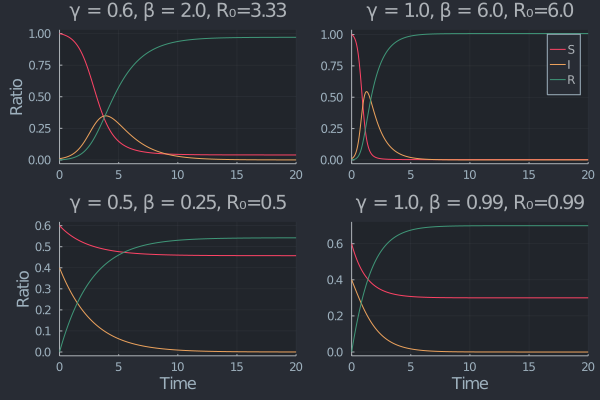

In [38]:
### plotting ###
labels = ["S" "I" "R"]
Rs = [1 .- sum(sir, dims=2) for sir in results] # recovered = N - (S + I)
R₀s = [p[2]/p[1] for p in ps] # basic reproductive numbers

p1 = plot(results[1], legend=false, title="γ = $(γs[1]), β = $(βs[1]), R₀=$(round(R₀s[1], digits=2))", xlabel="", ylabel="Ratio")
p2 = plot(results[2], label=labels, title="γ = $(γs[2]), β = $(βs[2]), R₀=$(round(R₀s[2], digits=2))", xlabel="")
p3 = plot(results[3], legend=false, title="γ = $(γs[3]), β = $(βs[3]), R₀=$(round(R₀s[3], digits=2))", xlabel="Time", ylabel="Ratio")
p4 = plot(results[4], legend=false, title="γ = $(γs[4]), β = $(βs[4]), R₀=$(round(R₀s[4], digits=2))", xlabel="Time")

# make subplot of all four results
plot(p1, p2, p3, p4, layout=4, titlefontsize=13)

In [69]:
savefig("figures/naiveSIR.svg")

### Phase Space Analysis

In [39]:
# arrays for storing results 
res_epid = []
res_no_epid = []

tspan = (0.0, 25.0)

p_ne = [0.4, 0.2] # no epidemic parameters
p_e = [1, 3]      # epidemic parameters


#= fixed I0 run=#
S0s = 0.4:0.1:1.0
I0 = 0.001

for S0 in S0s
    R0 = 1.0 - S0
    u0 = [S0, I0, R0]

    sir_e = solve_SIR(f!, u0, p_e, tspan)
    sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(res_epid, sir_e)
    push!(res_no_epid, sir_ne)
end


#= fixed R0 run=#
S0s = 0.1:0.1:1.0
for S0 in S0s
    I0 = 1.0 - S0
    u0 = [S0, I0, 0]

    sir_e = solve_SIR(f!, u0, p_e, tspan)
    sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(res_epid, sir_e)
    push!(res_no_epid, sir_ne)
end

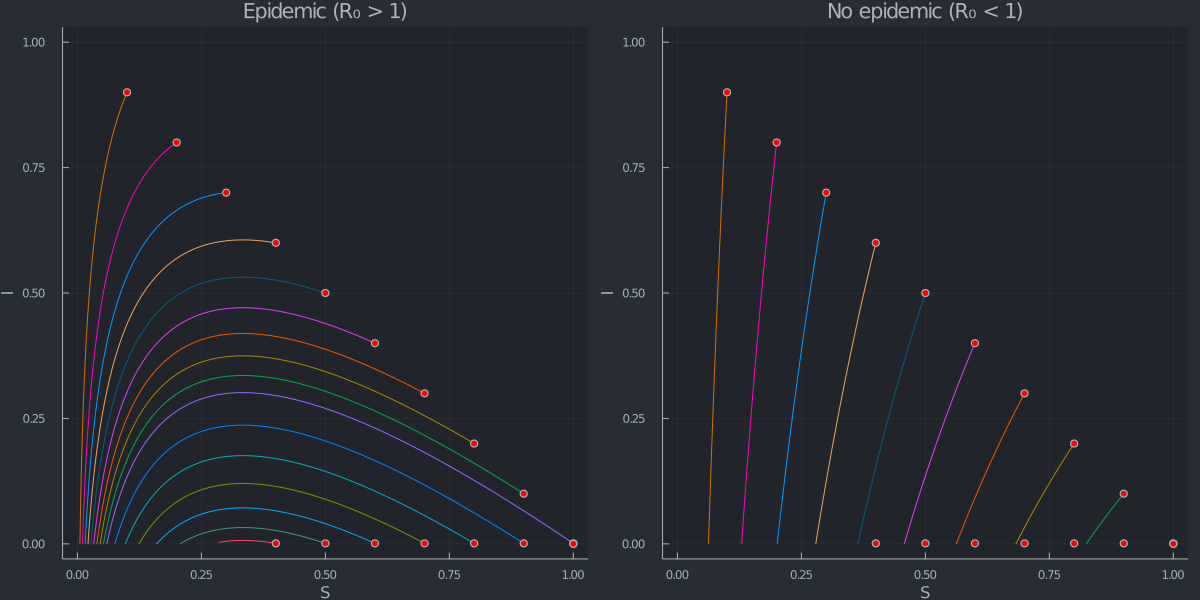

In [40]:
p1 = plot()
p2 = plot()

for i ∈ 1:length(res_epid)
    plot!(p1, res_epid[i], vars=(1, 2), legend=false)
    plot!(p2, res_no_epid[i], vars=(1, 2), legend=false)
    scatter!(p1, [res_epid[i][1,1]], [res_epid[i][2,1]], color=:red)
    scatter!(p2, [res_no_epid[i][1,1]], [res_no_epid[i][2,1]], color=:red)
end

title!(p1, "Epidemic (R₀ > 1)")
title!(p2, "No epidemic (R₀ < 1)")
plot(p1, p2, xlabel="S", ylabel="I", xlims=[0, 1.0], ylims=[0, 1.0], size=(1200, 600)) 

In [ ]:
savefig("figures/naiveSIR_phase.svg")

# Influenza Case

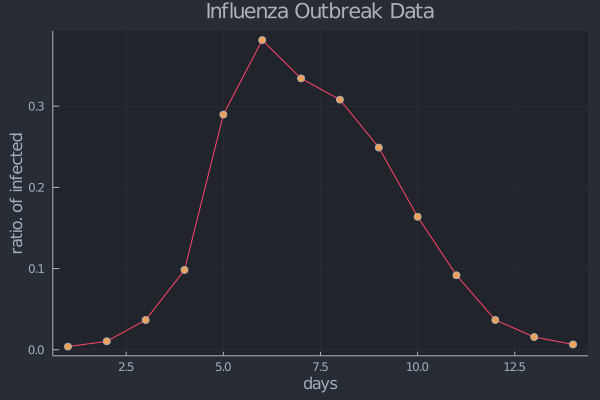

In [41]:
N = 763 # total number of students
days = 1:14 # duration of outbreak
cases = [3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5] ./ N # cases (ratio)

### plot the data ###
plot(days, cases, xlabel="days", ylabel="ratio. of infected", legend=false)
scatter!(days, cases, legend=false)
title!("Influenza Outbreak Data")

In [159]:
savefig("figures/data.svg")

#### Find the parameter values which best fit the model

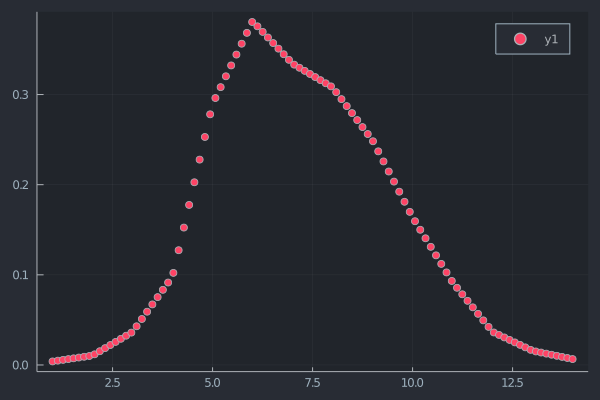

In [42]:
### get more data ###
using Interpolations
newdays = LinRange(1, 14, 100)

itp = interpolate(cases, BSpline(Linear()))
newcases = itp(newdays)
scatter(newdays, newcases)

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1278


Best parameter values: 
 
         γ =  0.48, 
 
         β =  1.95, 

         R₀ = 4.05 

         R² = 0.96
 


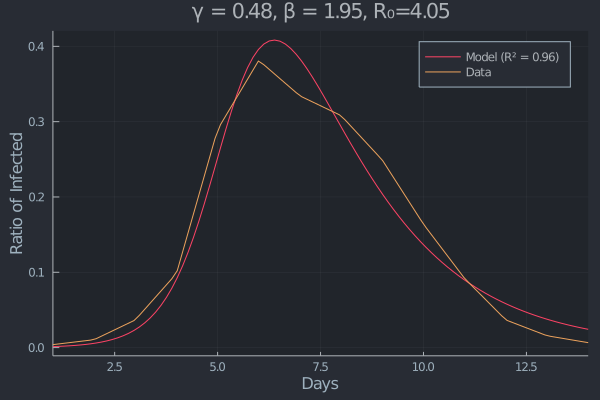

In [43]:
### find the best parameter by fitting a curve using least-squares ###
using LsqFit

# interpolated data as x- and y-values #
xdata = newdays  
ydata = newcases

#= experiment parameters =#
tspan = (1.0, 14.0)
S0 = (N - 1)/N  # N-1 initial susceptibles
I0 = 1.0/N      # one initial infected person
R0 = 0          # no initial recovered persons
u0 = [S0, I0, R0]

model(x, pp) = solve_SIR(f!, u0, pp, tspan)(x)[2,:] # solve the SIR model and return the ratio of infected at the given time(s) x

p0 = [0.5, 2.0] # initial guess

fit = curve_fit(model, xdata, ydata, p0) # fit the model

### extract best parameter values and compute R₀ ###
bestγ = fit.param[1]
bestβ = fit.param[2]
R₀ = bestβ/bestγ

### call the model to get values for computing R² ###
ymodel = model(xdata, fit.param)

### compute R² of fit ###
SStot = sum((ydata .- sum(ydata)/length(ydata)).^2)  # sum of total squares
SSres = sum((ydata .- ymodel) .^ 2)                  # sum of residual squares
R² = 1.0 - SSres/SStot

println("Best parameter values: \n 
         γ =  $(round(bestγ, digits=2)), \n 
         β =  $(round(bestβ, digits=2)), \n
         R₀ = $(round(R₀, digits=2)) \n
         R² = $(round(R², digits=2))\n ")

### visualize best fit ###

bestsol = solve_SIR(f!, u0, fit.param, tspan)

plot(bestsol, vars=(0, 2), plotdensity=length(xdata), label="Model (R² = $(round(R², digits=2)))")
plot!(xdata, ydata, label="Data")
xlabel!("Days")
ylabel!("Ratio of Infected")
title!("γ = $(round(bestγ, digits=2)), β = $(round(bestβ, digits=2)), R₀=$(round(R₀, digits=2))")

In [ ]:
savefig("figures/influenza_fit.svg")

## Preventing the Epidemic with Vaccination

Maximum ratio of infected: 0.06



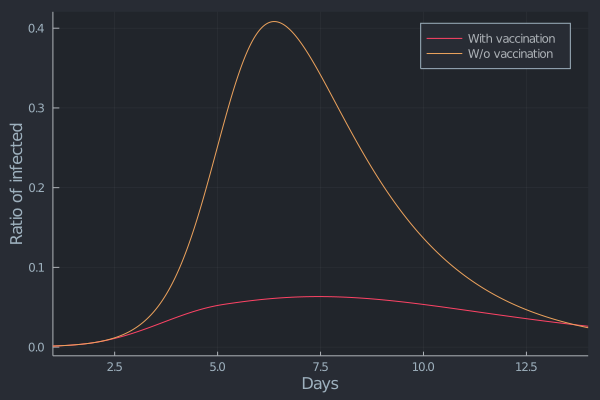

In [44]:
function f_vac!(du, u, p, t)
    """ Naive SIR with (100% effective) vaccination """
    
    S, I, R = u
    γ, β = p
    
    #= begin vaccination if within the set time frame =#
    if 2 <= t <= 5
        ν = 0.3
    else
        ν = 0.0
    end
    
    du[1] = -β*S*I - ν*S
    du[2] =  β*S*I - γ*I
    du[3] =  γ*I + ν*S
    
end

p = fit.param # best-fit parameters
sol = solve_SIR(f_vac!, u0, p, tspan)
println("Maximum ratio of infected: $(round(maximum(sol[2,:]), digits=2))\n")
plot(sol, vars=(0, 2), label="With vaccination ")#, title="Influenza Model with Vaccination")
plot!(bestsol, vars=(0, 2), label="W/o vaccination", xlabel="Days", ylabel="Ratio of infected")

In [19]:
savefig("figures/vacc.svg")

# Problem 2: Demography: Birth and Death Rates

In [45]:
function f2!(du, u, p, t)
    """ 
    SIR with birth and natural death rates
    """
    
    S, I, R = u
    γ, β, μ = p
    
    du[1] = -β*S*I + μ - μ*S
    du[2] = β*S*I - γ*I - μ*I
    du[3] = γ*I - μ*R
end

f2! (generic function with 1 method)

### 2.1: How do the dynamics change?

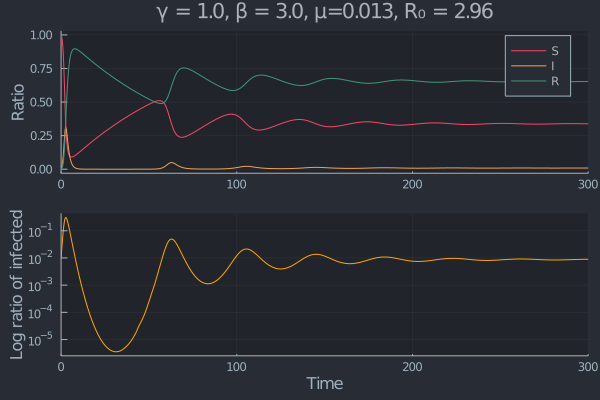

In [46]:
S0 = 1.0
I0 = 1e-2

# parameters and basic reproductive number
γ = 1.0
β = 3.0
μ = 1/75
R₀ = β/(γ + μ)

u0 = [S0, I0, 0]
p = [γ, β, μ]

tspan = (0, 300.0)

sol = solve_SIR(f2!, u0, p, tspan);

p1 = plot(sol, labels=["S" "I" "R"], ylabel="Ratio", xlabel="",
         title="γ = $γ, β = $β, μ=$(round(μ, digits=3)), R₀ = $(round(R₀, digits=2))")
p2 = plot(sol, vars=(0, 2), yscale=:log10, ylabel="Log ratio of infected", xlabel="Time", color=:orange, legend=false)
plot(p1, p2, layout=(2, 1))

In [38]:
savefig("figures/demographics.svg")

### 2.2: Capturing an Endemic State

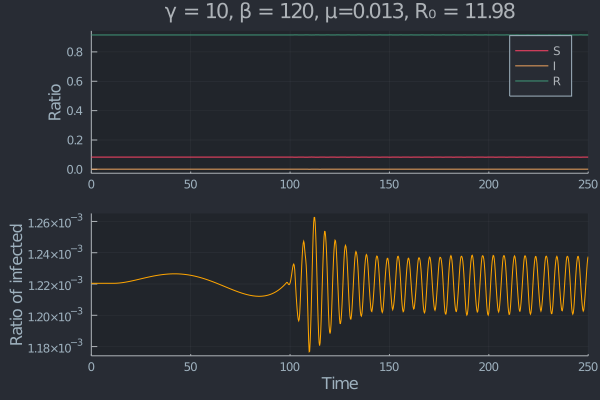

In [47]:
β = 120
γ = 10
μ = 1/75

R₀ = β/(γ + μ)

S0 = 1/R₀
I0 = μ/β*(R₀ - 1)
R0 = 1.0 - 1/R₀ - μ/β*(R₀ - 1)

u0 = [S0, I0, R0]

p = [γ, β, μ]

tspan = (0, 250.0)

sol = solve_SIR(f2!, u0, p, tspan);

p1 = plot(sol, labels=["S" "I" "R"], ylabel="Ratio", xlabel="",
         title="γ = $γ, β = $β, μ=$(round(μ, digits=3)), R₀ = $(round(R₀, digits=2))")
p2 = plot(sol, vars=(0, 2), ylabel="Ratio of infected", xlabel="Time", color=:orange, legend=false)
plot(p1, p2, layout=(2, 1))

In [184]:
savefig("figures/endemic.svg")

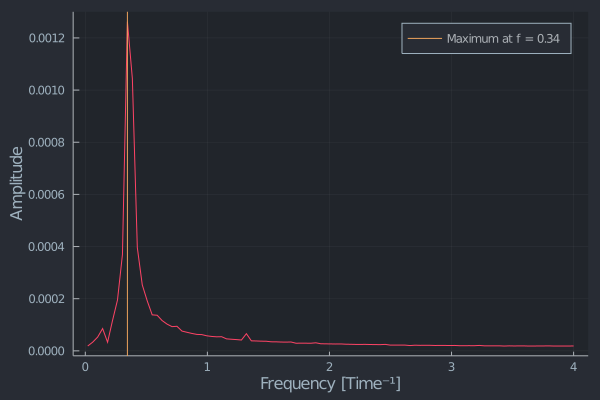

In [48]:
### fourier analysis ###
using FFTW

timedata = LinRange(200, 250, 200) # time interval to look at

data = sol(timedata, idxs=2) # infected values (interpolates to get 200 data points)

ff = fft(data) # fourier transform

T = timedata[end] - timedata[1] # total data time span
N = length(data)                # number of samples
Δf = 1.0/T                      # frequenecy resolution

freq = LinRange(Δf, N*Δf, Int(N/2)-1) # Nyquist-Shannon sampling theorem
ff = abs.(ff)[2:round(Int, N/2)]      # get absolute values of the fourier coefficients
maxf = freq[argmax(ff)]

plot(freq, ff, label="")
xlabel!("Frequency [Time⁻¹]")
ylabel!("Amplitude")
vline!([maxf], label="Maximum at f = $(round(maxf, digits=2))")

In [204]:
savefig("figures/fourier.svg")

## 2.2: Adding Death from Infection

In [49]:
function f3!(du, u, p, t)
    """ 
    SIR model with natural birth and death, 
    and death from infection 
    """
    
    N = sum(u) # N is no longer constant
    S, I, R = u
    γ, β, μ, ρ = p
    
    du[1] = -β*S*I/N + μ*N - μ*S
    du[2] =  β*S*I/N - (γ + μ)*I/(1 - ρ) 
    du[3] =  γ*I - μ*R
    
end

f3! (generic function with 1 method)

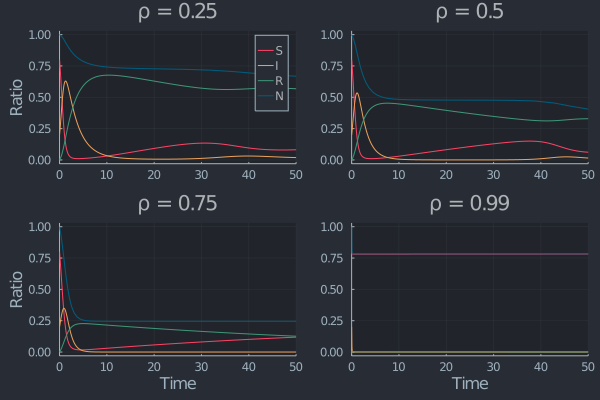

In [50]:
#N = 100

S0 = 0.8
I0 = 0.2
γ = 0.30
β = 3.0
μ = 1/75

# mortality rates to study
ρs = [0.25, 0.5, 0.75, 0.99]

u0 = [S0, I0, 0]
tspan = (0.0, 50.0)

results = []
for ρ in ρs
    p = [γ, β, μ, ρ]
    sol = solve_SIR(f3!, u0, p, tspan);
    push!(results, sol)
end

#= plot S, I, and R =#
labels = ["S" "I" "R"]
p1 = plot(results[1], title="ρ = $(ρs[1])", label=labels, xlabel="", ylabel="Ratio")
p2 = plot(results[2], title="ρ = $(ρs[2])", legend=false, xlabel="")
p3 = plot(results[3], title="ρ = $(ρs[3])", legend=false, xlabel="Time", ylabel="Ratio")
p4 = plot(results[4], title="ρ = $(ρs[4])", legend=false, xlabel="Time")

#= plot N =#
plot!(p1, results[1].t, sum(results[1], dims=1)', label="N")
plot!(p2, results[2].t, sum(results[2], dims=1)', legend=false)
plot!(p3, results[3].t, sum(results[3], dims=1)', legend=false)
plot!(p4, results[4].t, sum(results[4], dims=1)', legend=false)

plot(p1, p2, p3, p4)

In [209]:
savefig("figures/mortality.svg")

# Problem 3: Variation: The SEIRS Model



In [51]:
function SEIRS!(du, u, p, t)
    """ 
    Susceptible
    Exposed
    Infected
    Recovered
    Susceptible
    """
    
    N = sum(u)
    S, E, I, R = u
    γ, β₀, σ, Ω, η, μ, ω, A = p
    
    β = A*cos(ω*t) + β₀ # seasonal variation
    
    du[1] = -β*S*I/N - μ*S + μ*N + Ω*R #S: -infection - death + birth + immunity loss
    du[2] = β*S*I/N - (σ + μ)*E        #E: infection - latency - natural death 
    du[3] = σ*E - (γ + μ + η)*I        #I: latency - recovery - natural death - death from illness
    du[4] = γ*I - Ω*R - μ*R            #R: recovery - immunity loss - natural death  
end

R0_SEIRS(σ, μ, β, η) = (σ/(σ + μ))*(β/(σ + μ + η))

R0_SEIRS (generic function with 1 method)

In [52]:
β₀ = 3         # average rate of transmission
A = 1          # maximum deviation from β₀
ω = 1          # frequenecy of transmission oscillation
γ = 1.0        # recovery rate
η = 0.01       # death from infection
μ = 1/75       # birth and natural death

σs = [0.2, 1.0]        # latency
Ωs = [1/10, 1/2]       # immunity loss

S0 = 0.8
E0 = 0.2
R0 = 0
I0 = 0

u0 = [S0, E0, I0, R0]


ps =reshape([[γ, β₀, σ, Ω, η, μ, ω, A] for σ in σs, Ω in Ωs], 4, 1)
tspan = (0, 50.0);

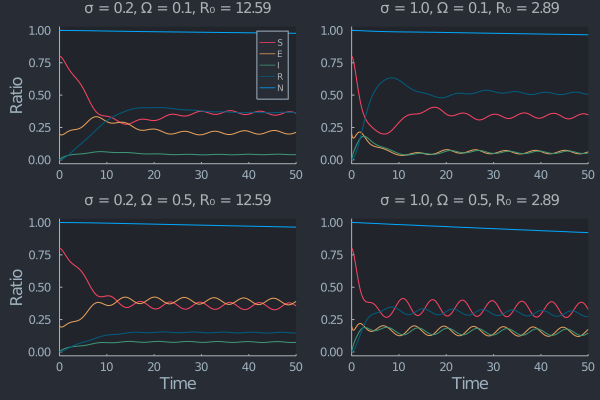

In [53]:
results = []

for p in ps
    sol = solve_SIR(SEIRS!, u0, p, tspan)
    
    push!(results, sol)
end

R0s = round.([R0_SEIRS(p[3], μ, β₀, η) for p in ps], digits=2)

#= plot S, E, I, and R =#
labels = ["S" "E" "I" "R"]
p1 = plot(results[1], title="σ = $(ps[1][3]), Ω = $(ps[1][4]), R₀ = $(R0s[1])", label=labels, xlabel="", ylabel="Ratio")
p2 = plot(results[2], title="σ = $(ps[2][3]), Ω = $(ps[2][4]), R₀ = $(R0s[2])", label=labels, xlabel="", ylabel="")
p3 = plot(results[3], title="σ = $(ps[3][3]), Ω = $(ps[3][4]), R₀ = $(R0s[3])", label=labels, xlabel="Time", ylabel="Ratio")
p4 = plot(results[4], title="σ = $(ps[4][3]), Ω = $(ps[4][4]), R₀ = $(R0s[4])", label=labels, xlabel="Time", ylabel="")

#= plot N =#
plot!(p1, results[1].t, sum(results[1], dims=1)', label="N")
plot!(p2, results[2].t, sum(results[2], dims=1)', legend=false)
plot!(p3, results[3].t, sum(results[3], dims=1)', legend=false)
plot!(p4, results[4].t, sum(results[4], dims=1)', legend=false)

plot(p1, p2, p3, p4, titlefontsize=10, legendfontsize=6, grid=false)

In [304]:
savefig("figures/seirs.svg")

In [12]:
### phase space analysis ###

S0s = 0.4:0.1:1.0
E0 = 0.001

σ = 0.2
Ω = 0.1

R₀ = R0_SEIRS(σ, μ, β₀, η)

tspan = (0.0, 50.0)

p = [γ, β₀, σ, Ω, η, μ, ω, A]

result = []

for S0 in S0s
    R0 = 1.0 - S0
    u0 = [S0, E0, 0, R0]

    sir_e = solve_SIR(SEIRS!, u0, p, tspan)
    #sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(result, sir_e)
    #push!(res_no_epid, sir_ne)
end


#I0 = 0.1
S0s = 0.1:0.1:1.0
for S0 in S0s
    E0 = 1.0 - S0
    u0 = [S0, E0, 0, 0]

    sir_e = solve_SIR(SEIRS!, u0, p, tspan)
    #sir_ne = solve_SIR(f!, u0, p_ne, tspan)

    push!(result, sir_e)
    #push!(res_no_epid, sir_ne)
end

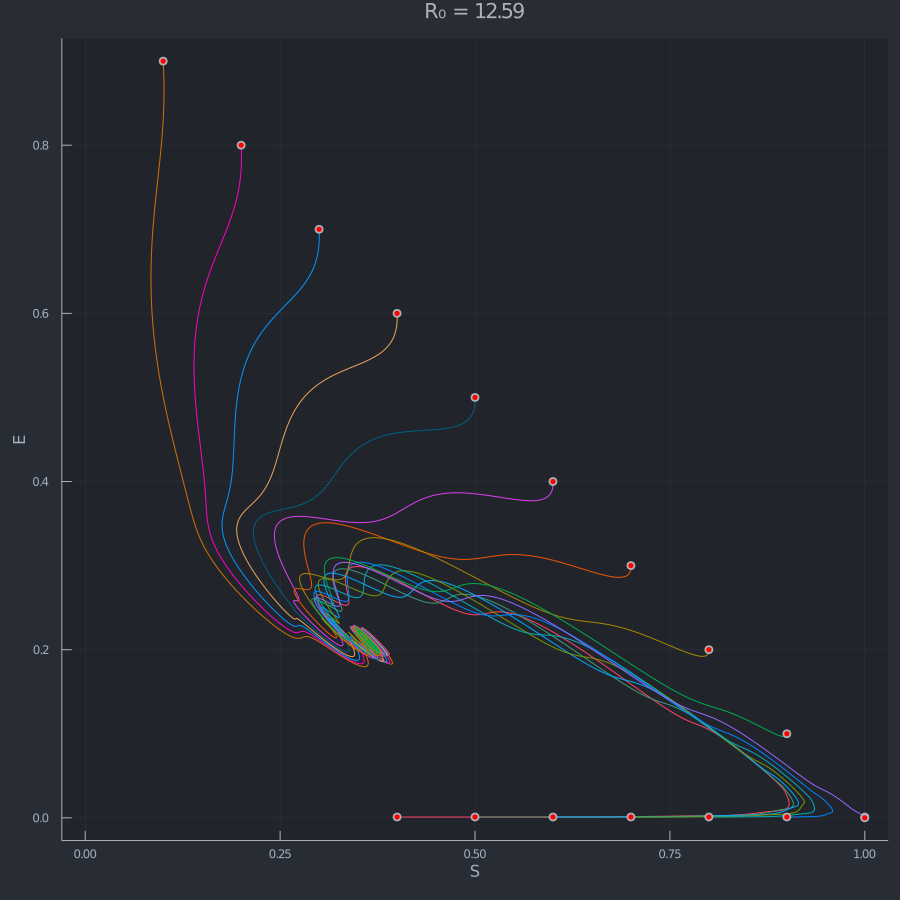

In [13]:
default(size=(900, 900))
p1 = plot()#plot(res_epid[1], vars=(1, 2), legend=false)

for i ∈ 1:length(result)
    plot!(p1, result[i], vars=(1, 2), legend=false)
    scatter!(p1, [result[i][1,1]], [result[i][2,1]], color=:red)
end

title!(p1, "R₀ = $(round(R₀, digits=2))")
plot(p1, xlabel="S", ylabel="E", xlims=[0, 1.0])#, ylims=[0, 1.0])#, size=(1200, 600)) 

In [14]:
savefig("figures/phase_seirs.svg")